For the cosserat rod equations, there are two kinematic equations (one related to translations and another related to rotations) and two dynamic equations (again, one related to translations and another related to rotations). So we tackle this problem in increasing levels of complexity via these milestones:

1) first tackle translations (which are easier to implement) by testing the equations on an elastic beam that is fixed on one end and has a small axial force on the one end. Because the beam is elastic, and the axial force is small, the entire beam behaves like a spring. We can then plot look at how much the beam stretches, which should correspond with analytical spring equations. This is milestone 1.

In [43]:
import numpy as np
from matplotlib import pyplot as plt
import time

# This class is not completely general: only supports uniform mass and single radius
class cosserat_rod:
    # initialize the rod
    def __init__(self, n_elements: int = 100, tot_length = 3.0, rod_density = 5E3, 
                 rod_radius = 0.25, E = 1E6, G = 1E4, velocities = 0, internal_forces = 0):
        
        '''Set up quantities that describe the rod'''
        self.tot_length = tot_length
        self.G = G
        self.E = E
        self.n_elements = n_elements
        self.n_nodes = self.n_elements+1
        element_length = tot_length/n_elements
        # straight rod
        self.positions = np.vstack((np.zeros((2,self.n_nodes)),np.arange(0.0, tot_length+element_length, element_length)))
        
        self.lengths_bold = self.positions[:, 1:] - self.positions[:, :-1]
        self.lengths_norm = np.linalg.norm(self.lengths_bold, axis=0, keepdims=True)
        self.reference_lengths_bold = self.positions[:, 1:] - self.positions[:, :-1]
        self.reference_lengths_norm = np.linalg.norm(self.reference_lengths_bold, axis=0, keepdims=True)
        
        self.directors = np.zeros((3, 3, n_elements))
        for idx in range(n_elements):
            self.directors[:, :, idx] = np.eye(3)
        
        self.rod_area = np.pi*rod_radius*rod_radius
        self.areas = self.rod_area*np.ones(self.n_elements,)
        
        element_mass = rod_density*element_length*self.rod_area
        self.masses = element_mass*np.ones(self.n_nodes,)
        self.masses[0] *= 0.5
        self.masses[-1] *= 0.5
        
        element_I = np.array([1/12 * element_mass * (3 * np.square(rod_radius) + np.square(element_length)), \
                     1/12 * element_mass * (3 * np.square(rod_radius) + np.square(element_length)), \
                     0.5 * element_mass * rod_radius * rod_radius])
                                        
        self.I = np.zeros((3, self.n_elements))
        self.I[0,:] = element_I[0]
        self.I[1,:] = element_I[1]
        self.I[2,:] = element_I[2]
        
        # Bend/twist matrix
        self.B = np.zeros((3, 3, n_elements))
        for idx in range(n_elements):
            self.B[:, :, idx] = np.diag(element_I) * np.array([self.E, self.E, self.G])
        
        self.J = rod_density*self.reference_lengths_norm*self.I
        
        lengths_next = np.roll(self.lengths_norm, -1, 1)
        D_ref = (lengths_next[:, :-1] + self.lengths_norm[:, :-1])/2
        print(D_ref)
        
        Q_next = np.roll(self.directors, -1, 2)[:, :, :-1]
        self.kappa_ref = -np.log(np.einsum('ijk, ljk -> ilk', Q_next, self.directors[:, :, :-1])) / D_ref     
        self*kappa_ref = np.nan_to_num(self.kappa_ref, 0)
        
        '''Set up quantities that will capture motion'''
        # This way of doing it is bad and should be fixed, will throw error if you try to input your own vals
        self.velocities = velocities if velocities else np.zeros((3, self.n_nodes)) 
        self.internal_forces = internal_forces if internal_forces else np.zeros((3, self.n_nodes))
        
        self.dilatations = self.lengths_norm / self.reference_lengths_norm
        
        self.shear_stiffness_matrix = np.zeros((3, 3, n_elements)) # S
        alpha_c = 4.0 / 3.0
        self.shear_stiffness_matrix[0, 0, :] = alpha_c * self.G * self.areas # S1
        self.shear_stiffness_matrix[1, 1, :] = alpha_c * self.G * self.areas # S2
        self.shear_stiffness_matrix[2, 2, :] = self.E * self.areas # S2
        
        self.tangents = self.lengths_bold / self.lengths_norm 
        
        self.shear_stretch_strains = self.dilatations * self.tangents - self.directors[:, 2, :]
        
        # to get sigma in material frame
        self.shear_stretch_strains = np.einsum('ijk, jk-> ik', self.directors, self.shear_stretch_strains)

    def rotate_rodrigues(t_frame, t_angle, about=[0.0,0.0,1.0], rad=False):
        """Rotates about one of the axes

        Parameters
        ----------
        t_frame : frame/np.array
            If frame object, then t_frame is given by the process function of
            the frame
            Else just a numpy array (vector/collection of vectors) which you
            want to rotate
        t_angle : float
            Angle of rotation, in degrees. Use `rad` to change behavior
        about : list/np.array
            Rotation axis specified in the world coordinates
        rad : bool
            Defaults to False. True indicates that the t_angle is in degrees rather
            than in radians. False indicates radians.

        Returns
        -------
        rot_frame : np.array 
            The rotated frame
        about : np.array
            The vector about which rotate_rodrigues effects rotation. Same as the
            input argument
        """
        # Check if its in radian or degree
        # Default assumed to be degree
        if not rad:
            t_angle = np.deg2rad(t_angle)

        def normalize(v):
            """ Normalize a vector/ matrix """
            norm = np.linalg.norm(v)
            if np.isclose(norm, 0.0):
                raise RuntimeError("Not rotating because axis specified to be zero")
                return v
            return v / norm

        def skew_symmetrize(v):
            """ Generate an orthogonal matrix from vector elements"""
            # Hard coded. Others are more verbose or not worth it
            return np.array([[0.0,-v[2],v[1]],
                             [v[2],0.0,-v[0]],
                             [-v[1],v[0],0.0]])


        # Convert about to np.array and normalize it
        about = normalize(np.array(about))

        # Form the 2D Euler rotation matrix
        c_angle = np.cos(t_angle)
        s_angle = np.sin(t_angle)

        # DS for 3D Euler rotation matrix
        # Composed of 2D matrices
        I = np.eye(3)
        K_mat = skew_symmetrize(about)
        # rot_matrix = I + K_mat @ (s_angle * I + (1-c_angle)* K_mat)
        rot_matrix = I + (s_angle * K_mat + (1.0 - c_angle) * (K_mat @ K_mat))   
        # print(rot_matrix, U_mat)

        if not (np.allclose(rot_matrix, I)):
            # actually do the rotation
            return rot_matrix @ t_frame, about
        else:
            return rot_matrix @ t_frame, about
            # raise RuntimeError("Not rotating because rotation is identity")
            
    def modified_diff(self, t_x):        
        temp = np.pad(t_x, (0,1), 'constant', constant_values=(0,0))
        return temp[:-1,:]-np.roll(temp,1)[:-1,:]
    
    # F = ma type calculations - key is to use position at half time step to recalc internal forces, then a
    def Newton2(self, temp_x):
        
        # update vals to use force_rule at dt/2
        self.lengths_bold = temp_x[:, 1:] - temp_x[:, :-1]
        self.lengths_norm = np.linalg.norm(self.lengths_bold, axis=0, keepdims=True)

        self.dilatations = self.lengths_norm / self.reference_lengths_norm
        self.tangents = self.lengths_bold / self.lengths_norm
        
        # update directors somewhere in here w rotations
        
        self.shear_stretch_strains = self.dilatations * self.tangents - self.directors[:, 2, :]
        self.shear_stretch_strains = np.einsum('ijk, jk-> ik', self.directors, self.shear_stretch_strains)
        
        self.internal_forces = np.einsum('jil, jkl, kl -> il ', self.directors, \
                                         self.shear_stiffness_matrix, self.shear_stretch_strains)
        node_forces = self.modified_diff(self.internal_forces)
        
        # potentially to implement damping
#         nu = 0.3
#         elem_vels = (self.velocities[:,1:] + self.velocities[:,:-1])/2
#         damping = -elem_vels*self.lengths_bold*nu
#         damping = self.modified_diff(damping)

        dvdt = (node_forces + self.ext_forces) / self.masses    
        return dvdt

    def position_verlet(self, dt, x, v, force_rule):
        temp_x = x + 0.5*dt*v
        v_n = v + dt * force_rule(temp_x)
        #self.velocities[:,0] = np.zeros(3,)
        x_n = temp_x + 0.5 * dt * v_n
        #self.positions[:,0] = np.zeros(3,)
        return x_n, v_n

    # run the simulation, specifying external conditions ** for now it's just for first benchmark
    def run(self, ext_forces, t_total = 100, dt = 3E-4):
        self.ext_forces = ext_forces
        n_iterations = int(np.ceil(t_total/dt))
        self.position_history = np.zeros((3, self.n_nodes, n_iterations))
        self.position_history[:, :, 0] = self.positions
        for time_step in range(n_iterations):
            self.positions, self.velocities = self.position_verlet(dt, self.positions, self.velocities, self.Newton2)
            # constrain the first element to the wall
            self.positions[:,0] = np.zeros(3,)
            self.velocities[:,0] = np.zeros(3,)
            self.position_history[:, :, time_step] = self.positions
        
        # print what disp should be
        print()
        print('Theoretical displacement (m): ', end = '')
        print(ext_forces[-1,-1]*self.tot_length/(self.E*self.rod_area-ext_forces[-1,-1]))
        print()
        return (self.positions, self.position_history)

[[0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
  0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
  0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
  0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
  0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
  0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
  0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
  0.03]]


<ipython-input-43-3c98b52d819d>:59: RuntimeWarning: divide by zero encountered in log
  self.kappa_ref = -np.log(np.einsum('ijk, ljk -> ilk', Q_next, self.directors[:, :, :-1])) / D_ref



Theoretical displacement (m): 0.00022920062769050053


Average end displacement (m): 0.00023152292446459993



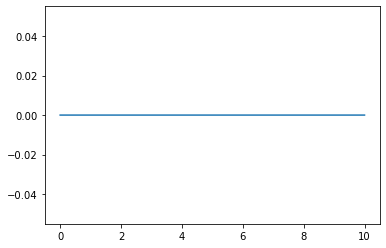

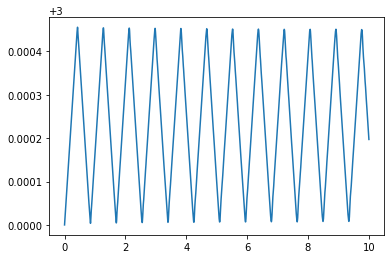

In [45]:
# Milestone 1
stretch_case = cosserat_rod()
t_total = 10
dt = 3E-4
ext_force = np.zeros((3, stretch_case.n_nodes))
ext_force[-1, -1] = 15
final_pos, position_history = stretch_case.run(ext_force, t_total, dt)

time_history = np.arange(0, t_total, dt)
plt.plot(time_history, position_history[-1,0,:])
plt.figure()
plt.plot(time_history, position_history[-1,-1,:])
print()
print('Average end displacement (m): ', end = '')
print(np.mean(position_history[-1,-1,:]-position_history[-1,-1, 0]))
print()


Theoretical displacement (m): 0.00022920062769050053


Average end displacement (m): 0.0002290149695530267



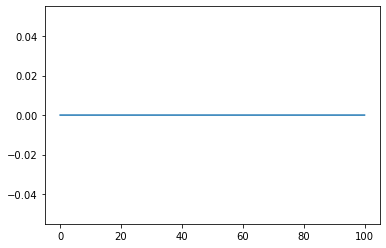

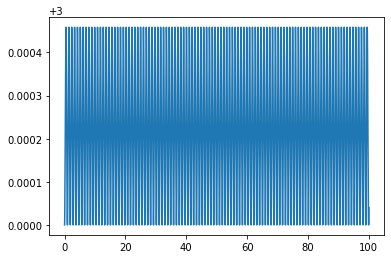

In [2]:
stretch_case = cosserat_rod(1)
t_total = 100
dt = 3E-4
ext_force = np.zeros((3, stretch_case.n_nodes))
ext_force[-1, -1] = 15
final_pos, position_history = stretch_case.run(ext_force, t_total, dt)

time_history = np.arange(0, t_total, dt)
plt.plot(time_history, position_history[-1,0,:])
plt.figure()
plt.plot(time_history, position_history[-1,-1,:])
print()
print('Average end displacement (m): ', end = '')
print(np.mean(position_history[-1,-1,:]-position_history[-1,-1, 0]))
print()